In [1]:
import os
import pickle
import sys
import warnings
from glob import glob
import re
import datetime
import itertools
from pyti.moving_average_convergence_divergence import moving_average_convergence_divergence as macd
from pyti.simple_moving_average import simple_moving_average as sma
from pyti.stochastic import percent_k as srv_k
from pyti.stochastic import percent_d as srv_d
from tqdm.notebook import tqdm
from fastprogress.fastprogress import  progress_bar
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, DayLocator, DateFormatter
#from mpl_finance import candlestick2_ohlc, volume_overlay
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import lightgbm as lgb
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy.stats import spearmanr
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification

In [2]:
dataset_dir="../data_dir/"

In [3]:
# 読み込むファイルを定義します。
inputs = {
    "stock_list": f"{dataset_dir}/stock_list.csv",
    "stock_price": f"{dataset_dir}/stock_price.csv",
    "stock_fin": f"{dataset_dir}/stock_fin.csv",
    # 本チュートリアルでは使用しないため、コメントアウトしています。
    # "stock_fin_price": f"{dataset_dir}/stock_fin_price.csv.gz",
    "stock_labels": f"{dataset_dir}/stock_labels.csv",
    "stock_fin_growth_rate": f"{dataset_dir}/stock_fin_growth_rate.csv",
    "train_X": f"{dataset_dir}/train_X.csv",
}

# ファイルを読み込みます
dfs = {}
for k, v in inputs.items():
    print(k)
    dfs[k] = pd.read_csv(v)
    # DataFrameのindexを設定します。
    if k == "stock_price":
        dfs[k].loc[:, "datetime"] = pd.to_datetime(
            dfs[k].loc[:, "EndOfDayQuote Date"]
        )
        dfs[k].set_index("datetime", inplace=True)
    elif k in ["stock_fin", "stock_fin_price", "stock_labels"]:
        dfs[k].loc[:, "datetime"] = pd.to_datetime(
            dfs[k].loc[:, "base_date"]
        )
        dfs[k].set_index("datetime", inplace=True)

stock_list
stock_price
stock_fin
stock_labels
stock_fin_growth_rate
train_X


In [31]:
def cross_X(x):
    return np.prod(x)

def get_features_for_predict(dfs, code, start_dt="2016-01-01"):
    """
    Args:
        dfs (dict)  : dict of pd.DataFrame include stock_fin, stock_price
        code (int)  : A local code for a listed company
        start_dt (str): specify date range
    Returns:
        feature DataFrame (pd.DataFrame)
    """
    # おおまかな手順の1つ目
    # stock_finデータを読み込み
    stock_fin = dfs["stock_fin"]
    periods = [10, 20, 40]
    # 特定の銘柄コードのデータに絞る
    stock_fin = stock_fin[stock_fin["Local Code"] == code]
    fin_data = stock_fin[~stock_fin.duplicated(subset=['Local Code', 'Result_FinancialStatement ReportType',"Result_FinancialStatement FiscalYear"],keep='last')]
    #前年の
    stock_labels=dfs["stock_labels"]
    stock_labels=stock_labels[stock_labels["Local Code"] == code]
    #print(stock_labels)
    fin_data = pd.merge(fin_data,stock_labels[["label_high_20","label_high_10","label_high_5","label_low_20","label_low_10","label_low_5"]],left_index = True,right_index = True)
    # 特徴量の作成には過去60営業日のデータを使用しているため、
    # 予測対象日からバッファ含めて土日を除く過去90日遡った時点から特徴量を生成します
    n = 90
    # 特徴量の生成対象期間を指定
    fin_data = fin_data.loc[pd.Timestamp(start_dt) - pd.offsets.BDay(n) :]
    seasons = stock_fin["Result_FinancialStatement ReportType"].unique()
    columns = fin_data.columns
    columns = columns.to_list()
    columns_list = ["Result_FinancialStatement NetSales","Result_FinancialStatement OrdinaryIncome","Result_FinancialStatement TotalAssets","Result_FinancialStatement NetAssets",
                   'Result_Dividend QuarterlyDividendPerShare','Result_Dividend AnnualDividendPerShare',"label_high_20","label_high_10","label_high_5","label_low_20","label_low_10","label_low_5"]
    for column in columns_list:
        a = "last "+column
#         print(a)
#         print(type(columns))
        columns.append(a)
    df_result = pd.DataFrame(index=[], columns=columns)
    # columns_list.append("base_date")
    # columns_list.append("Local Code")
    for season in seasons:
        #df["last "+column] = 0
        #print(columns_list)
        df_test = fin_data[fin_data["Result_FinancialStatement ReportType"]==season].copy()
        for column in columns_list:
            #print(columns)
            df_test["last "+column] = df_test[column]
            df_test["last "+column] = df_test[column].shift()
            #df = pd.merge(df,df_test[["last "+column,"base_date","Local Code"]],on = ["base_date","Local Code"],how="left")
            #df_ab, df_ac, on='a', how='left'
        #print(df_result)
        #print(df_test)
        df_result = pd.concat([df_result,df_test])
    df_result["NetSales_growth_rate"] = df_result["Result_FinancialStatement NetSales"] / df_result["last Result_FinancialStatement NetSales"]
    df_result["OrdinaryIncome_growth_rate"] = df_result["Result_FinancialStatement OrdinaryIncome"] / df_result["last Result_FinancialStatement OrdinaryIncome"]
    df_result["TotalAssets_growth_rate"] = df_result["Result_FinancialStatement TotalAssets"] / df_result["last Result_FinancialStatement TotalAssets"]
    df_result["NetAssets_growth_rate"] = df_result["Result_FinancialStatement NetAssets"] / df_result["last Result_FinancialStatement NetAssets"]
    df_result["QuarterlyDividendPerShare_growth_rate"] = df_result["Result_Dividend QuarterlyDividendPerShare"] / df_result["last Result_Dividend QuarterlyDividendPerShare"]
    df_result["AnnualDividendPerShare_growth_rate"] = df_result["Result_Dividend AnnualDividendPerShare"] / df_result["last Result_Dividend AnnualDividendPerShare"]
    #df_result = df_result.drop(["EndOfDayQuote ExchangeOfficialClose","macd_hist_shift","stocas_hist_shift","stocas_huge_signal"], axis=1)
#     # fin_dataのnp.float64のデータのみを取得
#     fin_data = fin_data.select_dtypes(include=["float64"])
#     # 欠損値処理
#     fin_feats = fin_data.fillna(0)

    # おおまかな手順の2つ目
    # stock_priceデータを読み込む
    price = dfs["stock_price"]
    # 特定の銘柄コードのデータに絞る
    price_data = price[price["Local Code"] == code]
    # 終値のみに絞る
    feats = price_data[["EndOfDayQuote ExchangeOfficialClose","EndOfDayQuote Volume"]]
    
    
    
    # 特徴量の生成対象期間を指定
    feats = feats.loc[pd.Timestamp(start_dt) - pd.offsets.BDay(n) :].copy()

    # 終値の20営業日リターン
    feats["return_1month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(20)
    # 終値の40営業日リターン
    feats["return_2month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(40)
    # 終値の60営業日リターン
    feats["return_3month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(60)
    # 終値の20営業日ボラティリティ
    feats["volatility_0.5month"] = (
        np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(10).std()
    )
    # 終値の40営業日ボラティリティ
    feats["volatility_1month"] = (
        np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(20).std()
    )
    # 終値の60営業日ボラティリティ
    feats["volatility_2month"] = (
        np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(40).std()
    )
    
    for period in periods:
        col = "5 windows volatility  {} mean".format(period)
        feats[col] = feats["volatility_0.5month"].rolling(period).mean()
    
    # ヒストリカル・ボラティリティ移動平均
    for period in periods:
        col = "25 windows volatility  {} mean".format(period)
        feats[col] = feats["volatility_1month"].rolling(period).mean()
        
    # ヒストリカル・ボラティリティ移動平均
    for period in periods:
        col = "75 windows volatility  {} mean".format(period)
        feats[col] = feats["volatility_2month"].rolling(period).mean()

    # ヒストリカル・ボラティリティ移動平均微分値
    for period in periods:
        col = "5 windows volatility  {} mean diff".format(period)
        feats[col] = feats["volatility_0.5month"].rolling(10).mean().pct_change(period)

    # ヒストリカル・ボラティリティ移動平均微分値
    for period in periods:
        col = "25 windows volatility  {} mean diff".format(period)
        feats[col] = feats["volatility_1month"].rolling(20).mean().pct_change(period)

    # ヒストリカル・ボラティリティ移動平均微分値
    for period in periods:
        col = "75 windows volatility  {} mean diff".format(period)
        feats[col] = feats["volatility_2month"].rolling(30).mean().pct_change(period)
    
    macd_period = {'long' : 26, 'short' : 12}
    sma_period  = 9
    feats['macd'] = macd(feats['EndOfDayQuote ExchangeOfficialClose'].values.tolist(), 12, 26)
    feats['macd_signal'] = sma(feats['macd'].values.tolist(), sma_period)
    feats["macd_hist"] = feats["macd"] - feats["macd_signal"]
    feats["macd_hist_shift"] = feats["macd_hist"].shift()
    feats.loc[feats["macd_hist"] < 0,"macd_hist_signal"] = -1
    feats.loc[feats["macd_hist"] > 0,"macd_hist_signal"] = 1
    feats.loc[feats["macd_hist"] == 0,"macd_hist_signal"] = 0
    feats["macd_cross_signal"] = feats["macd_hist"]*feats["macd_hist_shift"]
    feats.loc[feats["macd_cross_signal"] <= 0, "macd_cross_signal"] = 0
    feats.loc[feats["macd_cross_signal"] > 0, "macd_cross_signal"] = 1
    feats["macd_cross_sign_20"] = (1-feats["macd_cross_signal"].rolling(20).apply(cross_X,raw=True))*feats["macd_hist_signal"]
    feats["macd_cross_sign_10"] = (1-feats["macd_cross_signal"].rolling(10).apply(cross_X,raw=True))*feats["macd_hist_signal"]
    feats["macd_cross_sign_5"] = (1-feats["macd_cross_signal"].rolling(5).apply(cross_X,raw=True))*feats["macd_hist_signal"]
    #feats.loc[feats["macd_cross_sign"] > 0, "macd_cross_sign"] = 1
    mac_cols = ["macd","macd_signal","macd_hist"]
    mac_cross_cols = ["macd_cross_sign_20","macd_cross_sign_10"]
    feats["slow%k"] = srv_d(feats["EndOfDayQuote ExchangeOfficialClose"].values.tolist(), 14)*100
    feats["slow%d"] = feats["slow%k"].rolling(3).mean()
    feats["stocas_hist"] = feats["slow%k"] - feats["slow%d"]
    feats["stocas_hist_shift"] = feats["stocas_hist"].shift()
    feats["stocas_cross_signal"] = feats["stocas_hist"]*feats["stocas_hist_shift"]
    feats.loc[feats["stocas_cross_signal"] <= 0, "stocas_cross_signal"] = 0
    feats.loc[feats["stocas_cross_signal"] > 0, "stocas_cross_signal"] = 1
    feats.loc[feats["stocas_hist"] < 0,"stocas_hist_signal"] = -1
    feats.loc[feats["stocas_hist"] > 0,"stocas_hist_signal"] = 1
    feats.loc[feats["stocas_hist"] == 0,"stocas_hist_signal"] = 0
    feats["stocas_huge_signal"] = 0
    feats.loc[feats["slow%k"] <= 20,"stocas_huge_signal"] = 1
    feats.loc[feats["slow%k"] >= 80,"stocas_huge_signal"] = 1
    
    # feats["stocas_cross_sign_20"] = (1-feats["stocas_cross_signal"].rolling(20).apply(cross_X))*feats["stocas_hist_signal"]*feats["stocas_huge_signal"]
    # feats["stocas_cross_sign_10"] = (1-feats["stocas_cross_signal"].rolling(10).apply(cross_X))*feats["stocas_hist_signal"]*feats["stocas_huge_signal"]
    feats["stocas_cross_sign_5"] = (1-feats["stocas_cross_signal"].rolling(5).apply(cross_X,raw=True))*feats["stocas_hist_signal"]*feats["stocas_huge_signal"]
    stock_list = dfs["stock_list"]
    stock_data = stock_list[stock_list["Local Code"] == code]
    stock_data = stock_data[["33 Sector(Code)","17 Sector(Code)","IssuedShareEquityQuote IssuedShare","Size (New Index Series)"]]
    feats["IssuedShareEquityQuote IssuedShare"] = stock_data["IssuedShareEquityQuote IssuedShare"].values[0]
    #出来高移動平均線
    feats["Volume_5"] = feats["EndOfDayQuote Volume"].rolling(5).mean() / feats["IssuedShareEquityQuote IssuedShare"]
    feats["Volume_20"] = feats["EndOfDayQuote Volume"].rolling(20).mean() / feats["IssuedShareEquityQuote IssuedShare"]
    feats["Volume_40"] = feats["EndOfDayQuote Volume"].rolling(40).mean() / feats["IssuedShareEquityQuote IssuedShare"]
    
    #出来高移動平均線クロス
    feats["volumn_hist_5_20"] = feats["Volume_5"] - feats["Volume_20"]
    feats["volumn_hist_5_40"] = feats["Volume_5"] - feats["Volume_40"]
    feats["volumn_hist_20_40"] = feats["Volume_20"] - feats["Volume_40"]
    feats["volume_hist_shift"] = feats["volumn_hist_5_20"].shift()
    feats.loc[feats["volumn_hist_5_20"] < 0,"volume_hist_signal"] = -1
    feats.loc[feats["volumn_hist_5_20"] > 0,"volume_hist_signal"] = 1
    feats.loc[feats["volumn_hist_5_20"] == 0,"volume_hist_signal"] = 0
    feats["volume_cross_signal"] = feats["volumn_hist_5_20"]*feats["volume_hist_shift"]
    feats.loc[feats["volume_cross_signal"] <= 0, "volume_cross_signal"] = 0
    feats.loc[feats["volume_cross_signal"] > 0, "volume_cross_signal"] = 1
    feats["volume_cross_sign_20"] = (1-feats["volume_cross_signal"].rolling(20).apply(cross_X,raw=True))*feats["volume_hist_signal"]
    feats["volume_cross_sign_10"] = (1-feats["volume_cross_signal"].rolling(10).apply(cross_X,raw=True))*feats["volume_hist_signal"]
    feats["volume_cross_sign_5"] = (1-feats["volume_cross_signal"].rolling(5).apply(cross_X,raw=True))*feats["volume_hist_signal"]
    
    # おおまかな手順の3つ目
    # 欠損値処理
    #feats = feats.fillna(0)
    # 元データのカラムを削除
    
    
    #財務データの特徴量とマーケットデータの特徴量のインデックスを合わせる
    feats = feats.loc[feats.index.isin(df_result.index)]
    df_result = df_result.loc[df_result.index.isin(feats.index)]
    feats = pd.merge(df_result,feats,left_index= True,right_index = True ,how = "left")
    
    #print(stock_data["IssuedShareEquityQuote IssuedShare"])
    sector_17_dict = {1:0.041404, 2:0.056027, 3:0.052955, 4:0.064411, 5:0.091106, 6:0.046410, 7:0.047056, 8:0.070079, 9:0.052416, 10:0.061940, 11:0.062365, 12:0.052021,
                     13:0.022329, 14:0.030389, 15:0.190156, 16:0.109204, 17:0.083384}
    sector_33_dict = {50:	0.026789,
                        1050: 0.075618,
                        2050: 0.052140,
                        3050: 0.042869,
                        3100: 0.044244,
                        3150: 0.035982,
                        3200: 0.074299,
                        3250: 0.091106,
                        3300: 0.043225,
                        3350: 0.076820,
                        3400: 0.060586,
                        3450: 0.047813,
                        3500: 0.045698,
                        3550: 0.050873,
                        3600: 0.070079,
                        3650: 0.050197,
                        3700: 0.042787,
                        3750: 0.060784,
                        3800: 0.043177,
                        4050: 0.062365,
                        5050: 0.059168,
                        5100: 0.024505,
                        5150: 0.063092,
                        5200: 0.047985,
                        5250: 0.069475,
                        6050: 0.022329,
                        6100: 0.030389,
                        7050: 0.190156,
                        7100: 0.131484,
                        7150: 0.061564,
                        7200: 0.125792,
                        8050: 0.083384,
                        9050: 0.061318}
#     print("hello")
#     print(stock_data["33 Sector(Code)"])
    topix_dict = {'TOPIX Small 2':1, 'TOPIX Mid400':3, 'TOPIX Small 1':2, '-':0,'TOPIX Large70':4, 'TOPIX Core30':5}
    feats["en_33"] = sector_33_dict[stock_data["33 Sector(Code)"].values[0]]
    feats["en_17"] = sector_17_dict[stock_data["17 Sector(Code)"].values[0]]
    feats["Ordinary_rate_of_return"] = feats["Result_FinancialStatement OrdinaryIncome"] / feats["Result_FinancialStatement NetSales"]

    feats["sector17's_Ordinary_rate_of_return_diff"] = feats["Ordinary_rate_of_return"] - feats["en_33"]
    feats["sector33's_Ordinary_rate_of_return_diff"] = feats["Ordinary_rate_of_return"] - feats["en_17"]
    feats["en_topix"] = topix_dict[stock_data["Size (New Index Series)"].values[0]]
    feats["IssuedShareEquityQuote IssuedShare"] = stock_data["IssuedShareEquityQuote IssuedShare"].values[0]
    feats["Net_income_per_stock"] = feats["Result_FinancialStatement NetIncome"] / feats["IssuedShareEquityQuote IssuedShare"]
    #stock_data = stock_data["en_33","en_17","IssuedShareEquityQuote IssuedShare"]
    feats["PBR"] =feats["EndOfDayQuote ExchangeOfficialClose"] * feats["IssuedShareEquityQuote IssuedShare"] / feats["Result_FinancialStatement NetAssets"]
    feats["stability"] = feats["Result_FinancialStatement NetAssets"] / feats["Result_FinancialStatement TotalAssets"]
    feats["ROE"] = feats["Result_FinancialStatement NetIncome"] / feats["Result_FinancialStatement NetAssets"]
    feats["ROA"] = feats["Result_FinancialStatement NetIncome"] / feats["Result_FinancialStatement TotalAssets"]
    feats.loc[feats['Result_FinancialStatement CashFlowsFromOperatingActivities'] <= 0, 'Operating_cash_flow'] = 0
    feats.loc[feats['Result_FinancialStatement CashFlowsFromOperatingActivities'] > 0, 'Operating_cash_flow'] = 4
    feats.loc[feats['Result_FinancialStatement CashFlowsFromFinancingActivities'] <= 0, 'Financial_cash_flow'] = 0
    feats.loc[feats['Result_FinancialStatement CashFlowsFromFinancingActivities'] > 0, 'Financial_cash_flow'] = 1
    feats.loc[feats['Result_FinancialStatement CashFlowsFromInvestingActivities'] <= 0, 'Investing_cash_flow'] = 0
    feats.loc[feats['Result_FinancialStatement CashFlowsFromInvestingActivities'] > 0, 'Investing_cash_flow'] = 2
    feats["cash_evaluation"] = feats["Operating_cash_flow"] + feats["Financial_cash_flow"] + feats["Investing_cash_flow"]
    
    #feats["forecast_OperatingIncome_growth_rate"] = feats["Forecast_FinancialStatement OperatingIncome"] / feats["Result_FinancialStatement OperatingIncome"]
    feats["forecast_NetSales_growth_rate"] = feats["Forecast_FinancialStatement NetSales"] / feats["Result_FinancialStatement NetSales"]
    feats["forecast_OrdinaryIncome_growth_rate"] = feats["Forecast_FinancialStatement OrdinaryIncome"] / feats["Result_FinancialStatement OrdinaryIncome"]
    feats["forecast_NetIncome_growth_rate"] = feats["Forecast_FinancialStatement NetIncome"] / feats["Result_FinancialStatement NetIncome"]
    feats['QuarterlyDividendPerShare'] = feats['Result_Dividend QuarterlyDividendPerShare'] / feats['EndOfDayQuote ExchangeOfficialClose'] 
    feats['AnnualDividendPerShare'] = feats['Result_Dividend AnnualDividendPerShare'] / feats['EndOfDayQuote ExchangeOfficialClose'] 
    
    feats['Forecast_QuarterlyDividendPerShare_growth_rate'] = feats['Forecast_Dividend QuarterlyDividendPerShare'] / feats['Result_Dividend QuarterlyDividendPerShare'] 
    feats['forecast_AnnualDividendPerShare_growth_rate'] = feats['Forecast_Dividend AnnualDividendPerShare'] / feats['Result_Dividend AnnualDividendPerShare'] 
    #時価総額
    feats["market_cap"] = feats["EndOfDayQuote ExchangeOfficialClose"]*feats["IssuedShareEquityQuote IssuedShare"]
    
    """
    "Net_income_per_stock","PBR","stability","ROE","ROA","market_cap"
    """
    
    feats = feats.drop(["macd_hist_shift","stocas_hist_shift","stocas_huge_signal","Operating_cash_flow","Operating_cash_flow","Financial_cash_flow",
                       "Investing_cash_flow","macd_cross_signal","Result_FinancialStatement FiscalYear","Forecast_FinancialStatement FiscalYear","Forecast_Dividend FiscalYear","Result_Dividend FiscalYear"
                       ,"en_33","en_17","Ordinary_rate_of_return","Result_FinancialStatement CashFlowsFromOperatingActivities","Result_FinancialStatement CashFlowsFromFinancingActivities",
                       "Result_FinancialStatement CashFlowsFromInvestingActivities","Result_FinancialStatement NetSales","Result_FinancialStatement OperatingIncome",
                       "Result_FinancialStatement OrdinaryIncome","Result_FinancialStatement NetIncome","Result_FinancialStatement TotalAssets","Result_FinancialStatement NetAssets",
                       "Result_FinancialStatement CashFlowsFromOperatingActivities","Result_FinancialStatement CashFlowsFromFinancingActivities","Forecast_FinancialStatement NetSales",
                       "Forecast_FinancialStatement OperatingIncome","Forecast_FinancialStatement OrdinaryIncome","Forecast_FinancialStatement NetIncome","Result_Dividend QuarterlyDividendPerShare",
                       "Result_Dividend AnnualDividendPerShare","last Result_FinancialStatement NetSales","last Result_FinancialStatement OrdinaryIncome","last Result_FinancialStatement TotalAssets"
                       ,"last Result_FinancialStatement NetAssets","last Result_Dividend QuarterlyDividendPerShare","last Result_Dividend AnnualDividendPerShare",
                       "Forecast_Dividend QuarterlyDividendPerShare","Forecast_Dividend AnnualDividendPerShare","volume_hist_shift","volume_hist_signal","volume_cross_signal","volume_hist_signal",
                       "label_high_20","label_high_10","label_high_5","label_low_20","label_low_10","label_low_5"], axis=1)
    """
    'Result_FinancialStatement NetSales',
       'Result_FinancialStatement OperatingIncome',
       'Result_FinancialStatement OrdinaryIncome',
       'Result_FinancialStatement NetIncome',
       'Result_FinancialStatement TotalAssets',
       'Result_FinancialStatement NetAssets',
       'Result_FinancialStatement CashFlowsFromOperatingActivities',
       'Result_FinancialStatement CashFlowsFromFinancingActivities',
       'Result_FinancialStatement CashFlowsFromInvestingActivities',
       'Forecast_FinancialStatement NetSales',
       'Forecast_FinancialStatement OperatingIncome',
       'Forecast_FinancialStatement OrdinaryIncome',
       'Forecast_FinancialStatement NetIncome',
       'Result_Dividend QuarterlyDividendPerShare',
       'Result_Dividend AnnualDividendPerShare',
       'Forecast_Dividend QuarterlyDividendPerShare',
       'Forecast_Dividend AnnualDividendPerShare',
       'last Result_FinancialStatement NetSales',
       'last Result_FinancialStatement OrdinaryIncome',
       'last Result_FinancialStatement TotalAssets',
       'last Result_FinancialStatement NetAssets',
    """
    
    """
    'Forecast_Dividend QuarterlyDividendPerShare',
       'Forecast_Dividend AnnualDividendPerShare', 'NetSales_growth_rate',
       'OrdinaryIncome_growth_rate', 'TotalAssets_growth_rate',
       'NetAssets_growth_rate', 'QuarterlyDividendPerShare_growth_rate',
       'AnnualDividendPerShare_growth_rate', 'return_1month', 'return_2month',
       'return_3month', 'volatility_0.5month', 'volatility_1month',
       'volatility_2month', '5 windows volatility  10 mean',
       '5 windows volatility  20 mean', '5 windows volatility  40 mean',
       '25 windows volatility  10 mean', '25 windows volatility  20 mean',
       '25 windows volatility  40 mean', '75 windows volatility  10 mean',
       '75 windows volatility  20 mean', '75 windows volatility  40 mean',
       '5 windows volatility  10 mean diff',
       '5 windows volatility  20 mean diff',
       '5 windows volatility  40 mean diff',
       '25 windows volatility  10 mean diff',
       '25 windows volatility  20 mean diff',
       '25 windows volatility  40 mean diff',
       '75 windows volatility  10 mean diff',
       '75 windows volatility  20 mean diff',
       '75 windows volatility  40 mean diff', 'macd', 'macd_signal',
       'macd_hist', 'macd_hist_signal', 'macd_cross_sign_20',
       'macd_cross_sign_10', 'macd_cross_sign_5', 'slow%k', 'slow%d',
       'stocas_hist', 'stocas_cross_signal', 'stocas_hist_signal',
       'stocas_cross_sign_5', 'sector17's_Ordinary_rate_of_return_diff',
       'sector33's_Ordinary_rate_of_return_diff', 'en_topix',
       'IssuedShareEquityQuote IssuedShare', 'Net_income_per_stock', 'PBR',
       'stability', 'ROE', 'ROA', 'cash_evaluation',
       'forecast_NetSales_growth_rate', 'forecast_OrdinaryIncome_growth_rate',
       'forecast_NetIncome_growth_rate', 'QuarterlyDividendPerShare',
       'AnnualDividendPerShare', 'forecast_AnnualDividendPerShare_growth_rate',
       'code'
    """

    feats = feats.select_dtypes(include=[int, float])
    feats = feats.astype('float64')
    # 欠損値処理を行います。
    feats = feats.replace([np.inf, -np.inf], 0)
    feats = feats.replace({'NetSales_growth_rate': np.nan, 'OrdinaryIncome_growth_rate': np.nan,"TotalAssets_growth_rate":np.nan,
                          "NetAssets_growth_rate":np.nan,"QuarterlyDividendPerShare_growth_rate":np.nan,"AnnualDividendPerShare_growth_rate":np.nan,
                          "forecast_NetSales_growth_rate":np.nan,"forecast_OrdinaryIncome_growth_rate":np.nan,"forecast_NetIncome_growth_rate":np.nan,
                          "Forecast_QuarterlyDividendPerShare_growth_rate":np.nan,"forecast_AnnualDividendPerShare_growth_rate":np.nan}, 1)

    feats["33 Sector(Code)"]=stock_data["33 Sector(Code)"].values[0]
    feats["17 Sector(Code)"]=stock_data["17 Sector(Code)"].values[0]
    # 銘柄コードを設定
    feats["code"] = code


    return feats

In [32]:
df = get_features_for_predict(dfs, 6752)
df.T

,2016-02-25 00:00:00,2017-02-28 00:00:00,2018-02-05 00:00:00,2019-02-28 00:00:00,2020-04-27 00:00:00,2016-04-28 00:00:00,2017-05-11 00:00:00,2018-05-10 00:00:00,2019-05-09 00:00:00,2020-05-18 00:00:00,2016-08-31 00:00:00,2017-08-31 00:00:00,2018-08-31 00:00:00,2019-08-30 00:00:00,2020-08-28 00:00:00,2016-10-31 00:00:00,2017-10-31 00:00:00,2018-10-31 00:00:00,2019-10-31 00:00:00,2020-10-29 00:00:00
last label_high_20,NaN,1.474600e-01,4.826000e-02,5.994000e-02,7.320000e-03,NaN,4.083000e-02,8.385000e-02,5.442000e-02,-1.664000e-02,NaN,1.697000e-02,1.484100e-01,4.485000e-02,1.108400e-01,NaN,7.065000e-02,5.851000e-02,-3.601000e-02,1.435300e-01
last label_high_10,NaN,1.474600e-01,4.826000e-02,3.137000e-02,7.320000e-03,NaN,-1.689000e-02,2.359000e-02,5.442000e-02,-1.664000e-02,NaN,1.697000e-02,1.146400e-01,1.244000e-02,1.108400e-01,NaN,-4.239000e-02,5.851000e-02,-3.601000e-02,1.320800e-01
last label_high_5,NaN,1.474600e-01,4.785000e-02,3.137000e-02,7.320000e-03,NaN,-1.689000e-02,5.080000e-03,5.442000e-02,-1.664000e-02,NaN,1.697000e-02,1.945000e-02,1.244000e-02,4.121000e-02,NaN,-4.239000e-02,4.557000e-02,-3.601000e-02,1.288000e-01
last label_low_20,NaN,4.960000e-03,-3.650000e-02,-5.373000e-02,-9.171000e-02,NaN,-8.276000e-02,-4.900000e-02,-6.402000e-02,-1.341600e-01,NaN,-5.702000e-02,-2.832000e-02,-6.521000e-02,-1.500000e-02,NaN,-1.508700e-01,-3.205000e-02,-1.316500e-01,-3.160000e-03
last label_low_10,NaN,4.960000e-03,3.240000e-03,-5.373000e-02,-6.049000e-02,NaN,-8.276000e-02,-4.900000e-02,-2.657000e-02,-1.226300e-01,NaN,-4.901000e-02,-2.832000e-02,-6.521000e-02,-1.500000e-02,NaN,-1.508700e-01,-2.146000e-02,-1.056400e-01,-3.160000e-03
last label_low_5,NaN,4.960000e-03,3.240000e-03,-5.373000e-02,-3.844000e-02,NaN,-8.276000e-02,-4.900000e-02,1.408000e-02,-1.226300e-01,NaN,-3.205000e-02,-2.832000e-02,-4.561000e-02,-1.500000e-02,NaN,-1.147700e-01,-5.590000e-03,-1.020400e-01,-3.160000e-03
NetSales_growth_rate,1.000000e+00,9.433489e-01,1.105072e+00,1.028893e+00,9.461858e-01,1.000000e+00,9.721978e-01,1.086939e+00,1.002577e+00,9.360054e-01,1.000000e+00,1.066778e+00,1.076911e+00,9.414527e-01,7.360217e-01,1.000000e+00,1.103669e+00,1.038963e+00,9.591450e-01,7.957382e-01
OrdinaryIncome_growth_rate,1.000000e+00,9.109731e-01,1.352331e+00,9.387605e-01,8.088461e-01,1.000000e+00,1.267305e+00,1.376361e+00,1.100018e+00,6.988734e-01,1.000000e+00,1.393252e+00,1.247328e+00,5.499090e-01,5.458329e-02,1.000000e+00,1.271567e+00,1.012706e+00,6.990976e-01,6.756512e-01
TotalAssets_growth_rate,1.000000e+00,1.047765e+00,1.037419e+00,9.822624e-01,1.071674e+00,1.000000e+00,1.068962e+00,1.051511e+00,9.559354e-01,1.034019e+00,1.000000e+00,1.140114e+00,1.037202e+00,1.018417e+00,9.548026e-01,1.000000e+00,1.096140e+00,1.028579e+00,1.025318e+00,9.634976e-01
NetAssets_growth_rate,1.000000e+00,9.512282e-01,9.720845e-01,1.027552e+00,1.083239e+00,1.000000e+00,9.491030e-01,1.069520e+00,1.107492e+00,1.034180e+00,1.000000e+00,1.081376e+00,1.067087e+00,1.040034e+00,1.085946e+00,1.000000e+00,1.085524e+00,1.063710e+00,1.015180e+00,1.139119e+00


In [33]:
TRAIN_END = "2018-12-31"
VAL_START = "2019-02-01"
VAL_END = "2019-12-01"
TEST_START = "2020-01-01"

In [73]:
def get_features_and_label(dfs, codes, feature, label):
    """
    Args:
        dfs (dict[pd.DataFrame]): loaded data
        codes  (array) : target codes
        feature (pd.DataFrame): features
        label (str) : label column name
    Returns:
        train_X (pd.DataFrame): training data
        train_y (pd.DataFrame): label for train_X
        val_X (pd.DataFrame): validation data
        val_y (pd.DataFrame): label for val_X
        test_X (pd.DataFrame): test data
        test_y (pd.DataFrame): label for test_X
    """
    # 分割データ用の変数を定義
    trains_X, vals_X, tests_X = [], [], []
    trains_y, vals_y, tests_y = [], [], []

    # 銘柄コード毎に特徴量を作成
    for code in tqdm(codes):
        # 特徴量取得
        feats = feature[feature["code"] == code]

        # stock_labelデータを読み込み
        stock_labels = dfs["stock_labels"]
        # 特定の銘柄コードのデータに絞る
        stock_labels = stock_labels[stock_labels["Local Code"] == code]

        # 特定の目的変数に絞る
        labels = stock_labels[label]
        # nanを削除
        labels.dropna(inplace=True)

        if feats.shape[0] > 0 and labels.shape[0] > 0:
            # 特徴量と目的変数のインデックスを合わせる
            labels = labels.loc[labels.index.isin(feats.index)]
            feats = feats.loc[feats.index.isin(labels.index)]
            labels.index = feats.index

            # データを分割（ホールドアウト法）
            _train_X = feats[: TRAIN_END]
            _val_X = feats[VAL_START : VAL_END]
            _test_X = feats[TEST_START :]

            _train_y = labels[: TRAIN_END]
            _val_y = labels[VAL_START : VAL_END]
            _test_y = labels[TEST_START :]

            # データを配列に格納 (後ほど結合するため)
            trains_X.append(_train_X)
            vals_X.append(_val_X)
            tests_X.append(_test_X)

            trains_y.append(_train_y)
            vals_y.append(_val_y)
            tests_y.append(_test_y)

    # 銘柄毎に作成した説明変数データを結合します。
    train_X = pd.concat(trains_X)
    val_X = pd.concat(vals_X)
    test_X = pd.concat(tests_X)
    # 銘柄毎に作成した目的変数データを結合します。
    train_y = pd.concat(trains_y)
    val_y = pd.concat(vals_y)
    test_y = pd.concat(tests_y)

    return train_X, train_y, val_X, val_y, test_X, test_y

In [35]:
# 対象銘柄コードを定義
codes = [9984]
# 対象の目的変数を定義
label = "label_high_20"
# 特徴量を取得
feat = get_features_for_predict(dfs, codes[0])
# 特徴量と目的変数を入力し、分割データを取得
ret = get_features_and_label(dfs, codes, feat, label)
# for v in ret:
#     print(v.T)

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)


In [36]:
def get_codes(dfs):
    """
    Args:
        dfs (dict[pd.DataFrame]): loaded data
    Returns:
        array: list of stock codes
    """
    stock_list = dfs["stock_list"].copy()
    # 予測対象の銘柄コードを取得
    codes = stock_list[stock_list["prediction_target"] == True][
        "Local Code"
    ].values
    return codes

In [69]:
def sector_diff(df,column):
    columns=[column,"33 Sector(Code)"]
    sector_df = df[columns].groupby('33 Sector(Code)').median()
    sector_df = sector_df.rename(columns = {column:"sector_mean_"+column})
    df = pd.merge(df,sector_df,how="left",on="33 Sector(Code)")
    new_column_name = "true_" + column 
    df[new_column_name] = df[column] - df["sector_mean_"+column]
    df = df.drop(columns=("sector_mean_"+column))
    return df

In [78]:
a = sector_diff(feature,fin_column)
a.index = feature.index
feature = a
feature

,last label_high_20,last label_high_10,last label_high_5,last label_low_20,last label_low_10,last label_low_5,NetSales_growth_rate,OrdinaryIncome_growth_rate,TotalAssets_growth_rate,NetAssets_growth_rate,...,forecast_NetIncome_growth_rate,QuarterlyDividendPerShare,AnnualDividendPerShare,Forecast_QuarterlyDividendPerShare_growth_rate,forecast_AnnualDividendPerShare_growth_rate,market_cap,33 Sector(Code),17 Sector(Code),code,true_market_cap
2016-02-05,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,...,1.941748,NaN,NaN,1.000000,1.000000,2.895995e+10,50,1,1301,1.042984e+10
2017-02-17,0.03019,0.00000,0.00000,-0.05660,-0.05660,-0.05660,1.006065,1.051711,1.024527,1.100867,...,0.857493,0.001769,0.001769,12.000000,12.000000,3.088333e+10,50,1,1301,1.235321e+10
2018-02-09,0.13588,0.07749,0.04246,0.00177,0.00177,0.00177,1.101947,1.437920,1.062944,1.094069,...,0.969828,0.015748,0.015748,1.000000,1.000000,4.163676e+10,50,1,1301,2.310664e+10
2019-02-08,0.03806,0.03806,0.02100,-0.04331,-0.04331,-0.04331,0.997277,0.965068,1.045791,1.118033,...,1.279488,0.021322,0.021322,1.000000,1.000000,3.075219e+10,50,1,1301,1.222208e+10
2020-02-07,0.07854,0.07143,0.05828,0.00604,0.00604,0.00604,1.038694,0.759368,1.010849,1.059366,...,1.725129,0.024238,0.024238,1.000000,1.000000,3.156088e+10,50,1,1301,1.303077e+10
2016-05-09,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,...,0.444691,0.001916,0.001916,10.000000,10.000000,2.852282e+10,50,1,1301,9.992705e+09
2017-05-11,0.03448,0.02299,0.01533,-0.01149,-0.01149,-0.01149,1.043839,1.318053,1.029416,1.100845,...,1.114781,0.019737,0.019737,0.833333,0.833333,3.322198e+10,50,1,1301,1.469187e+10
2018-05-10,0.04441,0.04441,0.01480,-0.02632,-0.02632,-0.02632,1.077029,1.196279,1.091528,1.151707,...,0.996574,0.015727,0.015727,1.000000,1.000000,4.169140e+10,50,1,1301,2.316129e+10
2019-05-13,0.01048,0.01048,0.01048,-0.03408,-0.02621,-0.01180,1.005369,0.999324,1.078717,1.094142,...,1.304049,0.025126,0.025126,1.000000,1.000000,3.044620e+10,50,1,1301,1.191608e+10
2020-05-12,0.04379,0.04379,0.04379,-0.06317,-0.03589,-0.03589,1.024860,0.813712,0.969574,1.018659,...,1.472754,0.026799,0.026799,1.000000,1.000000,2.854468e+10,50,1,1301,1.001456e+10


In [92]:
# 対象の目的変数を定義
labels = {
    "label_high_20",
    "label_low_20",
}
# 目的変数毎にデータを保存するための変数
train_X, val_X, test_X = {}, {}, {}
train_y, val_y, test_y = {}, {}, {}

# 予測対象銘柄を取得
codes = get_codes(dfs)

# 特徴量を作成
buff = []
for code in progress_bar(codes):
    feat = get_features_for_predict(dfs, code)
    buff.append(feat)
feature = pd.concat(buff)
feature1 = feature.copy()
fin_columns = ["Net_income_per_stock","PBR","stability","ROE","ROA","market_cap"]
for fin_column in fin_columns:
    feature_index = feature1.index
    feature1 = sector_diff(feature1,fin_column)
    feature1.index = feature_index
#目的変数毎に処理
for label in  progress_bar(labels):
    # 特徴量と目的変数を取得
    _train_X, _train_y, _val_X, _val_y, _test_X, _test_y = get_features_and_label(dfs, codes, feature1, label)
    # 目的変数をキーとして値を保存
    train_X[label] = _train_X
    val_X[label] = _val_X
    test_X[label] = _test_X
    train_y[label] = _train_y
    val_y[label] = _val_y
    test_y[label] = _test_y


/opt/conda/lib/python3.7/site-packages/pyti/stochastic.py:21: RuntimeWarning: invalid value encountered in double_scalars
  np.min(data[idx+1-period:idx+1]))) for idx in range(period-1, len(data))]
/opt/conda/lib/python3.7/site-packages/pyti/stochastic.py:21: RuntimeWarning: invalid value encountered in double_scalars
  np.min(data[idx+1-period:idx+1]))) for idx in range(period-1, len(data))]
/opt/conda/lib/python3.7/site-packages/pyti/stochastic.py:21: RuntimeWarning: invalid value encountered in double_scalars
  np.min(data[idx+1-period:idx+1]))) for idx in range(period-1, len(data))]
/opt/conda/lib/python3.7/site-packages/pyti/stochastic.py:21: RuntimeWarning: invalid value encountered in double_scalars
  np.min(data[idx+1-period:idx+1]))) for idx in range(period-1, len(data))]
/opt/conda/lib/python3.7/site-packages/pyti/stochastic.py:21: RuntimeWarning: invalid value encountered in double_scalars
  np.min(data[idx+1-period:idx+1]))) for idx in range(period-1, len(data))]
/opt/conda

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)


KeyboardInterrupt: 

In [95]:
def sector_diff(df,column):
    columns=[column,"33 Sector(Code)"]
    sector_df = df[columns].groupby('33 Sector(Code)').median()
    sector_df = sector_df.rename(columns = {column:"sector_mean_"+column})
    df = pd.merge(df,sector_df,how="left",on="33 Sector(Code)")
    new_column_name = "true_" + column 
    df[new_column_name] = df[column] - df["sector_mean_"+column]
    df = df.drop(columns=("sector_mean_"+column))
    return df

In [96]:
feature1 = feature.copy()
fin_columns = ["Net_income_per_stock","PBR","stability","ROE","ROA","market_cap"]
for fin_column in fin_columns:
    feature_index = feature1.index
    feature1 = sector_diff(feature1,fin_column)
    feature1.index = feature_index
#目的変数毎に処理
for label in  progress_bar(labels):
    # 特徴量と目的変数を取得
    _train_X, _train_y, _val_X, _val_y, _test_X, _test_y = get_features_and_label(dfs, codes, feature1, label)
    # 目的変数をキーとして値を保存
    train_X[label] = _train_X
    val_X[label] = _val_X
    test_X[label] = _test_X
    train_y[label] = _train_y
    val_y[label] = _val_y
    test_y[label] = _test_y

In [97]:
train_X["label_high_20"].columns

Index(['last label_high_20', 'last label_high_10', 'last label_high_5',
       'last label_low_20', 'last label_low_10', 'last label_low_5',
       'NetSales_growth_rate', 'OrdinaryIncome_growth_rate',
       'TotalAssets_growth_rate', 'NetAssets_growth_rate',
       'QuarterlyDividendPerShare_growth_rate',
       'AnnualDividendPerShare_growth_rate',
       'EndOfDayQuote ExchangeOfficialClose', 'EndOfDayQuote Volume',
       'return_1month', 'return_2month', 'return_3month',
       'volatility_0.5month', 'volatility_1month', 'volatility_2month',
       '5 windows volatility  10 mean', '5 windows volatility  20 mean',
       '5 windows volatility  40 mean', '25 windows volatility  10 mean',
       '25 windows volatility  20 mean', '25 windows volatility  40 mean',
       '75 windows volatility  10 mean', '75 windows volatility  20 mean',
       '75 windows volatility  40 mean', '5 windows volatility  10 mean diff',
       '5 windows volatility  20 mean diff',
       '5 windows volatil

In [98]:
feature1 = feature.copy()
fin_columns = ["Net_income_per_stock","PBR","stability","ROE","ROA","market_cap"]
for fin_column in fin_columns:
    feature_index = feature1.index
    feature1 = sector_diff(feature1,fin_column)
    feature1.index = feature_index

In [86]:
feature=feature.drop("true_market_cap",axis=1)

In [87]:
feature

,last label_high_20,last label_high_10,last label_high_5,last label_low_20,last label_low_10,last label_low_5,NetSales_growth_rate,OrdinaryIncome_growth_rate,TotalAssets_growth_rate,NetAssets_growth_rate,...,forecast_OrdinaryIncome_growth_rate,forecast_NetIncome_growth_rate,QuarterlyDividendPerShare,AnnualDividendPerShare,Forecast_QuarterlyDividendPerShare_growth_rate,forecast_AnnualDividendPerShare_growth_rate,market_cap,33 Sector(Code),17 Sector(Code),code
2016-02-05,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,...,1.116071,1.941748,NaN,NaN,1.000000,1.000000,2.895995e+10,50,1,1301
2017-02-17,0.03019,0.00000,0.00000,-0.05660,-0.05660,-0.05660,1.006065,1.051711,1.024527,1.100867,...,1.167315,0.857493,0.001769,0.001769,12.000000,12.000000,3.088333e+10,50,1,1301
2018-02-09,0.13588,0.07749,0.04246,0.00177,0.00177,0.00177,1.101947,1.437920,1.062944,1.094069,...,0.984010,0.969828,0.015748,0.015748,1.000000,1.000000,4.163676e+10,50,1,1301
2019-02-08,0.03806,0.03806,0.02100,-0.04331,-0.04331,-0.04331,0.997277,0.965068,1.045791,1.118033,...,1.172572,1.279488,0.021322,0.021322,1.000000,1.000000,3.075219e+10,50,1,1301
2020-02-07,0.07854,0.07143,0.05828,0.00604,0.00604,0.00604,1.038694,0.759368,1.010849,1.059366,...,1.510574,1.725129,0.024238,0.024238,1.000000,1.000000,3.156088e+10,50,1,1301
2016-05-09,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,...,0.461976,0.444691,0.001916,0.001916,10.000000,10.000000,2.852282e+10,50,1,1301
2017-05-11,0.03448,0.02299,0.01533,-0.01149,-0.01149,-0.01149,1.043839,1.318053,1.029416,1.100845,...,1.078458,1.114781,0.019737,0.019737,0.833333,0.833333,3.322198e+10,50,1,1301
2018-05-10,0.04441,0.04441,0.01480,-0.02632,-0.02632,-0.02632,1.077029,1.196279,1.091528,1.151707,...,1.036737,0.996574,0.015727,0.015727,1.000000,1.000000,4.169140e+10,50,1,1301
2019-05-13,0.01048,0.01048,0.01048,-0.03408,-0.02621,-0.01180,1.005369,0.999324,1.078717,1.094142,...,1.217862,1.304049,0.025126,0.025126,1.000000,1.000000,3.044620e+10,50,1,1301
2020-05-12,0.04379,0.04379,0.04379,-0.06317,-0.03589,-0.03589,1.024860,0.813712,0.969574,1.018659,...,1.247228,1.472754,0.026799,0.026799,1.000000,1.000000,2.854468e+10,50,1,1301


In [99]:
column1 = train_X["label_high_20"].columns
for column in column1:
    train_X["label_high_20"][column] = train_X["label_high_20"][column].fillna(train_X["label_high_20"][column].median())

In [100]:
train_X["label_high_20"].isnull().sum()

last label_high_20                                0
last label_high_10                                0
last label_high_5                                 0
last label_low_20                                 0
last label_low_10                                 0
last label_low_5                                  0
NetSales_growth_rate                              0
OrdinaryIncome_growth_rate                        0
TotalAssets_growth_rate                           0
NetAssets_growth_rate                             0
QuarterlyDividendPerShare_growth_rate             0
AnnualDividendPerShare_growth_rate                0
EndOfDayQuote ExchangeOfficialClose               0
EndOfDayQuote Volume                              0
return_1month                                     0
return_2month                                     0
return_3month                                     0
volatility_0.5month                               0
volatility_1month                                 0
volatility_2

'\n0.00   -0.272730\n0.25    0.010938\n0.50    0.050060\n0.80    0.147702\n0.90    0.232182\n0.99    0.733710\n1.00    5.569770\n'

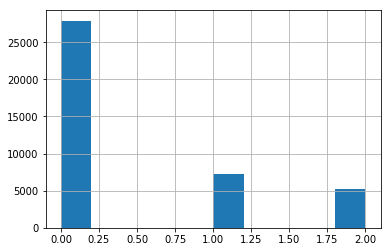

In [101]:
train_high_df = pd.concat([train_X["label_high_20"],train_y["label_high_20"]],axis=1)
train_high_df.loc[train_high_df['label_high_20'] >= -0.3, 'quantery1'] = 0
train_high_df.loc[train_high_df['label_high_20'] >= 0.1, 'quantery1'] = 1
train_high_df.loc[train_high_df['label_high_20'] >= 0.2, 'quantery1'] = 2
# train_high_df.loc[train_high_df['label_high_20'] >= 0.3, 'quantery1'] = 3
# train_high_df.loc[train_high_df['label_high_20'] >= 0.4, 'quantery1'] = 4
# train_high_df.loc[train_high_df['label_high_20'] >= 0.5, 'quantery1'] = 5
# train_high_df.loc[train_high_df['label_high_20'] >= 0.6, 'quantery1'] = 6
# train_high_df.loc[train_high_df['label_high_20'] >= 0.7, 'quantery1'] = 7
# train_high_df.loc[train_high_df['label_high_20'] >= 0.8, 'quantery1'] = 8
# train_high_df.loc[train_high_df['label_high_20'] >= 0.9, 'quantery1'] = 9
# train_high_df.loc[train_high_df['label_high_20'] >= 1, 'quantery1'] = 10
train_high_df["quantery1"].hist()
"""
0.00   -0.272730
0.25    0.010938
0.50    0.050060
0.80    0.147702
0.90    0.232182
0.99    0.733710
1.00    5.569770
"""

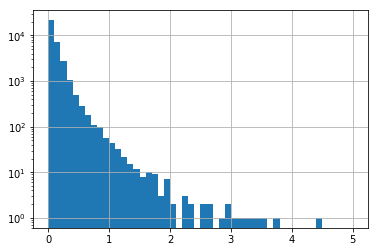

In [102]:
train_y["label_high_20"].hist(bins=50,range=(0,5),log=True)

In [103]:
# ファンダメンタル情報
column1 = [x for x in train_X[label].columns if x != "code"]

In [104]:
# class Model(params):
#     @classmethod
#     def fit(cls, tr_x,tr_y,val_x,val_y):
#         pred_model =lgb.train(params,
#                 lgb_train,
#                 valid_sets=lgb_eval,
#                 num_boost_round=10000,
#                 early_stopping_rounds=100,
#                 verbose_eval=50)
        

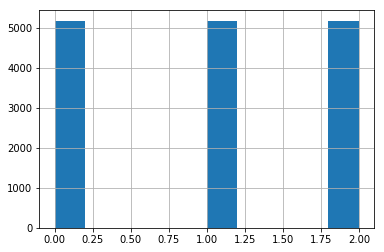

In [105]:
rus = RandomUnderSampler(random_state=0)
train_high_df, y_train_undersampled = rus.fit_resample(train_high_df.drop(columns="quantery1"), train_high_df["quantery1"])
y_train_undersampled.hist()

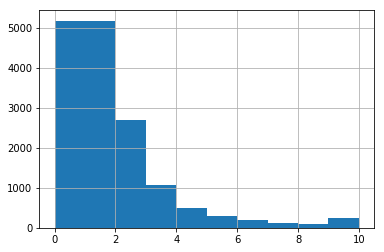

In [106]:
train_high_df.loc[train_high_df['label_high_20'] >= -0.5, 'quantery1'] = 0
train_high_df.loc[train_high_df['label_high_20'] >= 0.1, 'quantery1'] = 1
train_high_df.loc[train_high_df['label_high_20'] >= 0.2, 'quantery1'] = 2
train_high_df.loc[train_high_df['label_high_20'] >= 0.3, 'quantery1'] = 3
train_high_df.loc[train_high_df['label_high_20'] >= 0.4, 'quantery1'] = 4
train_high_df.loc[train_high_df['label_high_20'] >= 0.5, 'quantery1'] = 5
train_high_df.loc[train_high_df['label_high_20'] >= 0.6, 'quantery1'] = 6
train_high_df.loc[train_high_df['label_high_20'] >= 0.7, 'quantery1'] = 7
train_high_df.loc[train_high_df['label_high_20'] >= 0.8, 'quantery1'] = 8
train_high_df.loc[train_high_df['label_high_20'] >= 0.9, 'quantery1'] = 9
train_high_df.loc[train_high_df['label_high_20'] >= 1, 'quantery1'] = 10
train_high_df["quantery1"].hist()

last label_high_20                                0
last label_high_10                                0
last label_high_5                                 0
last label_low_20                                 0
last label_low_10                                 0
last label_low_5                                  0
NetSales_growth_rate                              0
OrdinaryIncome_growth_rate                        0
TotalAssets_growth_rate                           0
NetAssets_growth_rate                             0
QuarterlyDividendPerShare_growth_rate             0
AnnualDividendPerShare_growth_rate                0
EndOfDayQuote ExchangeOfficialClose               0
EndOfDayQuote Volume                              0
return_1month                                     0
return_2month                                     0
return_3month                                     0
volatility_0.5month                               0
volatility_1month                                 0
volatility_2

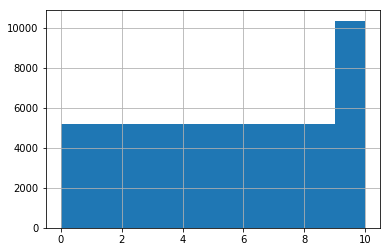

In [107]:
sm = SMOTE(sampling_strategy='auto', k_neighbors=1, n_jobs=1, random_state=42)
print(train_high_df.drop(columns="quantery1").isnull().sum())
# リサンプリング(サンプル生成)
X_resampled, y_resampled = sm.fit_resample(train_high_df.drop(columns="quantery1"), train_high_df["quantery1"])

y_resampled.hist()

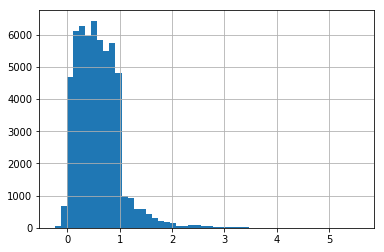

In [108]:
X_resampled["label_high_20"].hist(bins=50)

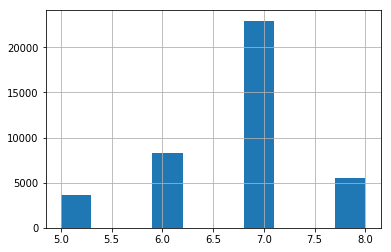

In [109]:
column1 = train_X["label_low_20"].columns
for column in column1:
    train_X["label_low_20"][column] = train_X["label_low_20"][column].fillna(train_X["label_low_20"][column].median())
train_low_df = pd.concat([train_X["label_low_20"],train_y["label_low_20"]],axis=1)
train_low_df.loc[train_low_df['label_low_20'] >= -0.8, 'quantery1'] = 5
# train_low_df.loc[train_low_df['label_low_20'] >= -0.7, 'quantery1'] = 1
# train_low_df.loc[train_low_df['label_low_20'] >= -0.6, 'quantery1'] = 2
# train_low_df.loc[train_low_df['label_low_20'] >= -0.5, 'quantery1'] = 3
# train_low_df.loc[train_low_df['label_low_20'] >= -0.4, 'quantery1'] = 4
# train_low_df.loc[train_low_df['label_low_20'] >= -0.3, 'quantery1'] = 5
train_low_df.loc[train_low_df['label_low_20'] >= -0.2, 'quantery1'] = 6
train_low_df.loc[train_low_df['label_low_20'] >= -0.1, 'quantery1'] = 7
train_low_df.loc[train_low_df['label_low_20'] >= 0, 'quantery1'] = 8
train_low_df["quantery1"].hist()

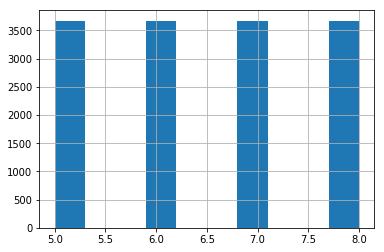

In [110]:
rus = RandomUnderSampler(random_state=0)
train_low_df, y_train_undersampled = rus.fit_resample(train_low_df.drop(columns="quantery1"), train_low_df["quantery1"])
y_train_undersampled.hist()

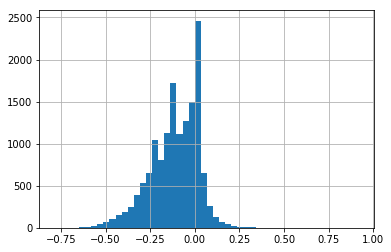

In [111]:
train_low_df["label_low_20"].hist(bins=50)

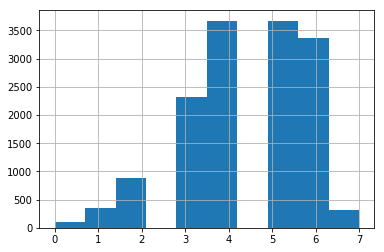

In [112]:
#train_low_df = pd.concat([train_X["label_low_20"],train_y["label_low_20"]],axis=1)
train_low_df.loc[train_low_df['label_low_20'] >= -0.8, 'quantery1'] = 0
train_low_df.loc[train_low_df['label_low_20'] >= -0.5, 'quantery1'] = 1
train_low_df.loc[train_low_df['label_low_20'] >= -0.4, 'quantery1'] = 2
train_low_df.loc[train_low_df['label_low_20'] >= -0.3, 'quantery1'] = 3
train_low_df.loc[train_low_df['label_low_20'] >= -0.2, 'quantery1'] = 4
train_low_df.loc[train_low_df['label_low_20'] >= -0.1, 'quantery1'] = 5
train_low_df.loc[train_low_df['label_low_20'] >= 0, 'quantery1'] = 6
train_low_df.loc[train_low_df['label_low_20'] >= 0.1, 'quantery1'] = 7
# train_low_df.loc[train_low_df['label_low_20'] >= 0.05, 'quantery1'] = 8
# train_low_df.loc[train_low_df['label_low_20'] >= 0.1, 'quantery1'] = 9
# train_low_df.loc[train_low_df['label_low_20'] >= 0.15, 'quantery1'] = 10
train_low_df["quantery1"].hist()

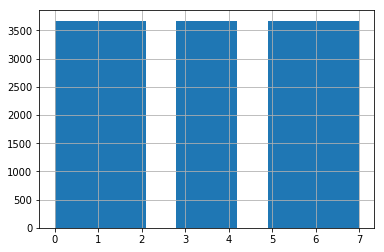

In [113]:
sm = SMOTE(sampling_strategy='auto', k_neighbors=1, n_jobs=1, random_state=42)
#print(train_high_df.drop(columns="quantery1").isnull().sum())
# リサンプリング(サンプル生成)
X_resampled_low, y_resampled = sm.fit_resample(train_low_df.drop(columns="quantery1"), train_low_df["quantery1"])

y_resampled.hist()

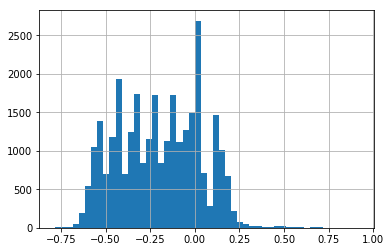

In [114]:
X_resampled_low["label_low_20"].hist(bins=50)

In [115]:
train2_X,train2_y = {},{}
train2_X["label_high_20"] = X_resampled.drop(columns="label_high_20")
train2_X["label_low_20"] = X_resampled_low.drop(columns="label_low_20")
train2_y["label_high_20"] = X_resampled["label_high_20"]
train2_y["label_low_20"] = X_resampled_low["label_low_20"]

In [116]:
def save_model(model, label, model_path="../opt/model"):
    # モデル保存先ディレクトリを作成
    os.makedirs(model_path, exist_ok=True)
    with open(os.path.join(model_path, f"my_model_{label}.pkl"), "wb") as f:
        # モデルをpickle形式で保存
        pickle.dump(model, f)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21398
[LightGBM] [Info] Number of data points in the train set: 29384, number of used features: 84
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] S

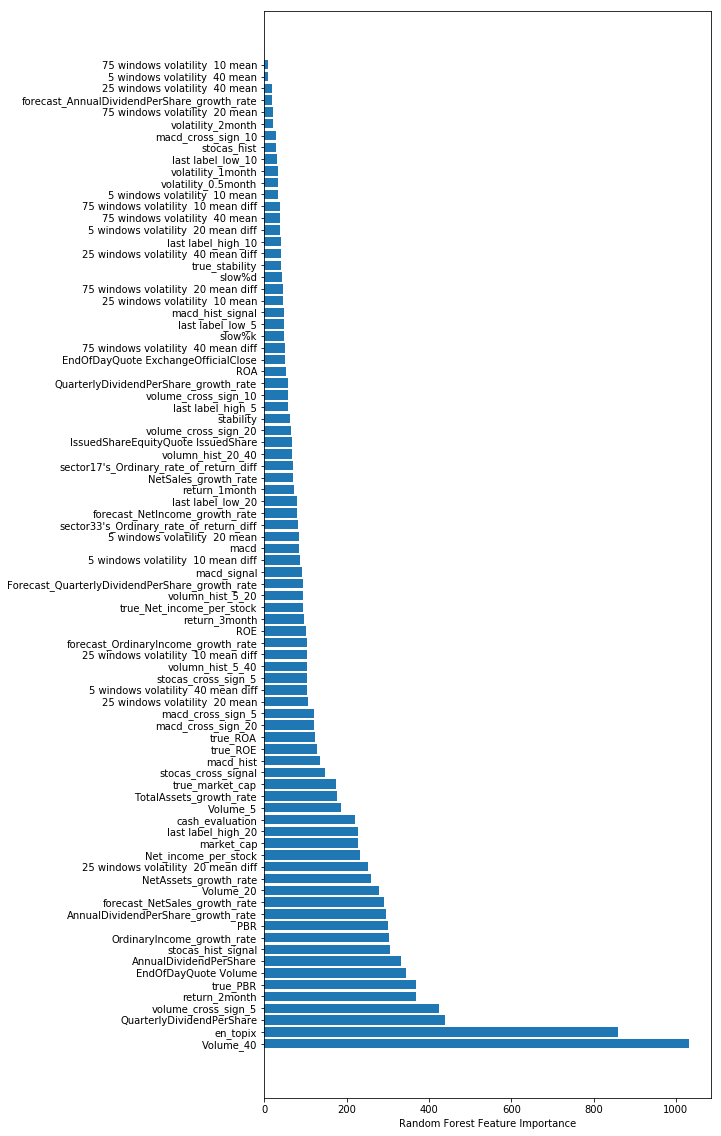

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21419
[LightGBM] [Info] Number of data points in the train set: 57046, number of used features: 84
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] S

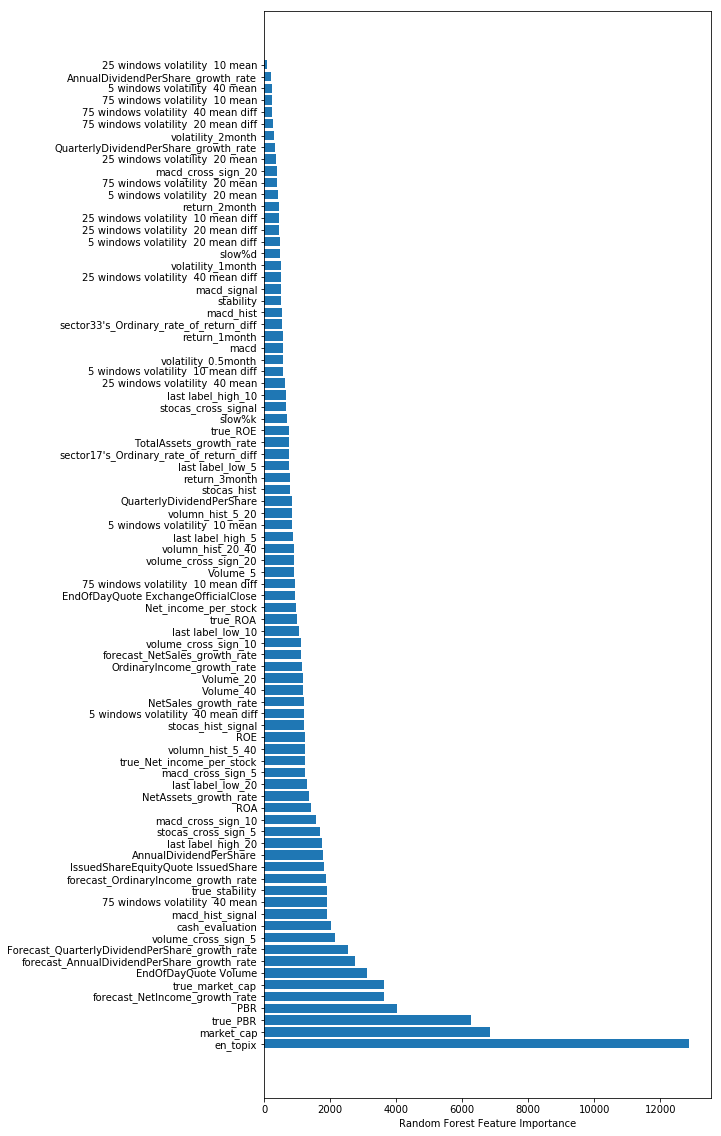

In [117]:
column1 = [x for x in train_X[label].columns if x not in ["code", "33 Sector(Code)", "17 Sector(Code)"]]
# モデルを定義
models = {
    "gbm": lgb,
}


# 学習済みモデル保存用
trained_models = dict()
# 結果保存用
all_results = dict()
# モデル毎に処理
for model in tqdm(models.keys()):
    all_results[model] = dict()
    trained_models[model] = dict()
    result = dict()
    trained_models[model] = dict()
    # 目的変数毎に処理
    for label in tqdm(labels):
        if len(test_X[label]) > 0:
            params = {"boosting":"gbdt",
                      "objective":"regression",
                      "learning_rate":0.05,
                      "gamma":0.0,
                      "alpha":0.9,
                      "lambda":1.0,
                      "min_data_in_leaf":1,
                      "colsample_bytree":0.8,
                      "subsample":0.5,
                      "num_boost_round":1000,
                      "early_stopping_round":50,
                      'max_depth' : 5}
            lgb_train = lgb.Dataset(train2_X[label][column1], train2_y[label])
            lgb_eval = lgb.Dataset(val_X[label][column1], val_y[label] )

            # 学習
            pred_model =lgb.train(params,
                            lgb_train,
                            valid_sets=lgb_eval)
            print(label)
            """
            # 学習済みモデル保存
                trained_models[model][col][label] = pred_model
                # 結果データ作成
                result[label] = test_X[label][["code"]].copy()
                result[label]["datetime"] = test_X[label][columns[col]].index
                # 予測
                result[label]["predict"] = pred_model.predict(test_X[label][columns[col]])
                result[label]["predict_dir"] = np.sign(result[label]["predict"])
                # 実際の結果
                result[label]["actual"] = test_y[label].values
                result[label]["actual_dir"] = np.sign(result[label]["actual"])
                result[label].dropna(inplace=True)
            """
            # 予測
            #predicted = gbm.predict(X_test)
            result[label] = pd.DataFrame(
                pred_model.predict(test_X[label][column1]), columns=["predict"]
            )
            # 学習済みモデル保存
            trained_models[model][label] = pred_model
            # 結果データ作成
            result[label] = test_X[label][["code"]].copy()
            result[label]["datetime"] = test_X[label].index
            # 予測
            test_columns = test_X[label].columns
            for column in test_columns:
                test_X[label][column] = test_X[label][column].fillna(test_X[label][column].median())
            result[label]["predict"] = pred_model.predict(test_X[label][column1])
            importance = pd.DataFrame(pred_model.feature_importance(importance_type='gain'), index=train_X[label][column1].columns, columns=['importance'])
            importance = importance.sort_values('importance', ascending=False)
            fig, ax = plt.subplots(figsize=(8, 20))
            ax.barh(importance.index, importance["importance"])
            ax.set_xlabel("Random Forest Feature Importance")
            plt.show()
            result[label]["predict_dir"] = np.sign(result[label]["predict"])
            # 実際の結果
            result[label]["actual"] = test_y[label].values
            result[label]["actual_dir"] = np.sign(result[label]["actual"])
            result[label].dropna(inplace=True)

        all_results[model] = result

In [118]:
results = []
for model in all_results.keys():
    tmp = pd.concat(all_results[model])
    tmp["model"] = model
    results.append(tmp)
results = pd.concat(results)
results["label"] = [x[0] for x in results.index]
results.head(5)

code   datetime   predict  predict_dir   actual  \
label_high_20 2020-02-07  1301 2020-02-07  0.072040          1.0  0.13588   
              2020-05-12  1301 2020-05-12  0.110453          1.0  0.01048   
              2020-08-07  1301 2020-08-07  0.167303          1.0  0.00498   
              2020-11-06  1301 2020-11-06  0.103361          1.0  0.02804   
              2020-02-05  1332 2020-02-05  0.150559          1.0  0.04982   

                          actual_dir model          label  
label_high_20 2020-02-07         1.0   gbm  label_high_20  
              2020-05-12         1.0   gbm  label_high_20  
              2020-08-07         1.0   gbm  label_high_20  
              2020-11-06         1.0   gbm  label_high_20  
              2020-02-05         1.0   gbm  label_high_20

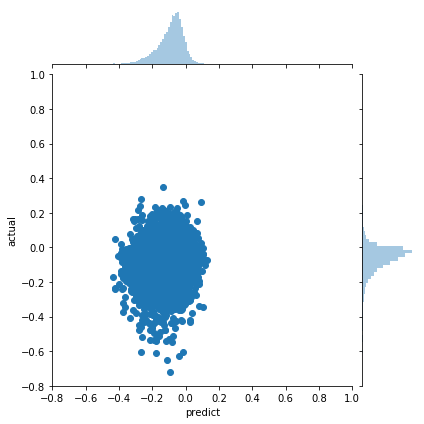

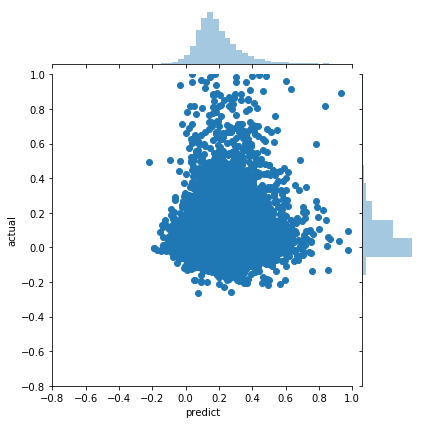

,index,RMSE,accuracy,spearman_corr,corr,R^2 score,feature,model,# of samples
0,label_low_20,0.103376,0.804457,0.12404,0.159286,0.025372,last label_high_20 last label_hig...,gbm,13956
1,label_high_20,0.221,0.798725,0.0899847,0.114508,0.0131121,last label_high_20 last label_hig...,gbm,13956


In [119]:
# 結果保存用変数
all_metrics = []

# データセット毎に処理
matrix = dict()
# モデル毎に処理
for model in models:
    # 目的変数毎に処理
    for label in labels:
        # 処理対象データに絞り込み
        tmp_df = results[(results["label"] == label)]
        rmse = np.sqrt(mean_squared_error(tmp_df["predict"], tmp_df["actual"]))
        sns.jointplot(data=tmp_df, x="predict", y="actual",xlim=(-0.8,1),ylim=[-0.8,1])
        plt.show()
        # 精度
        accuracy = accuracy_score(tmp_df["predict_dir"], tmp_df["actual_dir"])
        # 相関係数
        corr = np.corrcoef(tmp_df["actual"], tmp_df["predict"])[0, 1]
        # 順位相関
        spearman_corr = spearmanr(tmp_df["actual"], tmp_df["predict"])[0]
        # 結果を保存
        matrix[label] = [rmse, accuracy, spearman_corr,corr, corr**2, feature, model, tmp_df.shape[0]]
    res = pd.DataFrame.from_dict(matrix).T
    res.columns = ["RMSE","accuracy","spearman_corr","corr","R^2 score","feature", "model", "# of samples"]
    all_metrics.append(res)
all_metrics = pd.concat(all_metrics)
all_metrics.reset_index()

In [120]:
numeric_cols = ["RMSE","accuracy","spearman_corr","corr","R^2 score"]
for col in numeric_cols:
    all_metrics[col] = all_metrics[col].astype(float)
# indexとデータセット毎に平均を計算
agg = all_metrics.reset_index().groupby(["index"]).agg("mean")
agg

,RMSE,accuracy,spearman_corr,corr,R^2 score
index,,,,,
label_high_20,0.221000,0.798725,0.089985,0.114508,0.013112
label_low_20,0.103376,0.804457,0.124040,0.159286,0.025372


In [121]:
# 保存した学習済みモデルから、提出するモデルを選択してpickle形式で保存します。
# 使用するモデルや特徴量を変更する際は、学習時と推論時で同一の特徴量をモデルに
# 入力するために提出用のpredictor.pyについても変更する必要があることにご注意ください。

# モデルの保存先を指定します。
model_path = "../opt/ml/model"
# モデルの種類
models = ["gbm"]
# 使用する特徴量カラム
columns = ["fundamental+technical"]
# 目的変数
labels = [
    "label_high_20",
    "label_low_20",
]

# モデル毎に処理
for model in models:
    # 特徴量毎に処理
    # 目的変数毎に処理
    for label in labels:
        # 学習済みモデルを取得
        pred_model = trained_models[model][label]
        # モデルを保存
        save_model(pred_model, label, model_path=model_path)

In [122]:
stock_price = dfs["stock_price"]

In [123]:
stock_price["EndOfDayQuote Volume"].isnull().sum()

0

In [124]:
train_X["label_high_20"]

,last label_high_20,last label_high_10,last label_high_5,last label_low_20,last label_low_10,last label_low_5,NetSales_growth_rate,OrdinaryIncome_growth_rate,TotalAssets_growth_rate,NetAssets_growth_rate,...,market_cap,33 Sector(Code),17 Sector(Code),code,true_Net_income_per_stock,true_PBR,true_stability,true_ROE,true_ROA,true_market_cap
2016-02-05,0.05244,0.033545,0.02288,-0.04734,-0.03966,-0.03064,1.000000,1.000000,1.000000,1.000000,...,2.895995e+10,50,1,1301,5.810933e-05,-79557.241872,-0.228753,0.013338,-0.004912,1.042984e+10
2017-02-17,0.03019,0.000000,0.00000,-0.05660,-0.05660,-0.05660,1.006065,1.051711,1.024527,1.100867,...,3.088333e+10,50,1,1301,1.785308e-04,-118260.152132,-0.213496,0.059954,0.006083,1.235321e+10
2018-02-09,0.13588,0.077490,0.04246,0.00177,0.00177,0.00177,1.101947,1.437920,1.062944,1.094069,...,4.163676e+10,50,1,1301,2.091852e-04,160007.909307,-0.207053,0.063664,0.007535,2.310664e+10
2016-05-09,0.05244,0.033545,0.02288,-0.04734,-0.03966,-0.03064,1.000000,1.000000,1.000000,1.000000,...,2.852282e+10,50,1,1301,1.190521e-04,-79635.747166,-0.189718,0.042951,0.004196,9.992705e+09
2017-05-11,0.03448,0.022990,0.01533,-0.01149,-0.01149,-0.01149,1.043839,1.318053,1.029416,1.100845,...,3.322198e+10,50,1,1301,1.760602e-04,-7847.885867,-0.172801,0.060342,0.010050,1.469187e+10
2018-05-10,0.04441,0.044410,0.01480,-0.02632,-0.02632,-0.02632,1.077029,1.196279,1.091528,1.151707,...,4.169140e+10,50,1,1301,2.482581e-04,109424.707952,-0.158427,0.074758,0.015387,2.316129e+10
2016-08-05,0.05244,0.033545,0.02288,-0.04734,-0.03966,-0.03064,1.000000,1.000000,1.000000,1.000000,...,2.841354e+10,50,1,1301,4.853020e-06,-80623.739720,-0.207256,-0.011084,-0.009397,9.883422e+09
2017-08-04,0.02692,0.026920,0.02692,0.00000,0.00000,0.00385,1.088840,2.902632,1.056970,1.111546,...,3.518907e+10,50,1,1301,2.342867e-05,60460.748906,-0.195573,-0.005547,-0.007800,1.665896e+10
2018-08-03,0.05590,0.048140,0.01863,-0.01553,-0.01553,-0.01553,1.019580,0.668178,1.046033,1.160681,...,3.562620e+10,50,1,1301,5.219042e-06,-115393.738678,-0.169494,-0.016338,-0.009880,1.709609e+10
2016-11-04,0.05244,0.033545,0.02288,-0.04734,-0.03966,-0.03064,1.000000,1.000000,1.000000,1.000000,...,2.947358e+10,50,1,1301,6.295913e-05,-67383.002056,-0.212029,0.015208,-0.003689,1.094347e+10


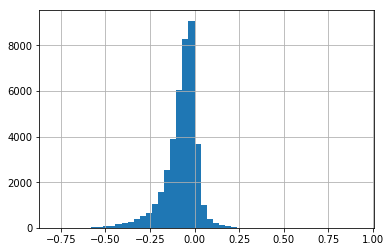

In [72]:
train_y["label_low_20"].hist(bins = 50)

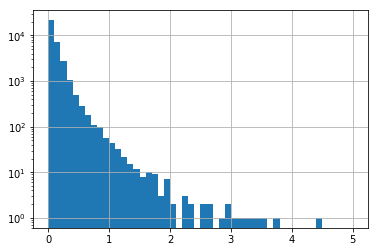

In [50]:
train_y["label_high_20"].hist(bins=50,range=(0,5),log=True)

In [55]:
train_y["label_high_20"].quantile([0, 0.25, 0.5, 0.8,0.9, 0.99,1.0])

0.00   -0.272730
0.25    0.010938
0.50    0.050060
0.80    0.147702
0.90    0.232182
0.99    0.733710
1.00    5.569770
Name: label_high_20, dtype: float64

In [56]:
test_y["label_high_20"].quantile([0, 0.25, 0.5, 0.8,0.9, 0.99,1.0])

0.00   -0.265490
0.25    0.009670
0.50    0.047070
0.80    0.139420
0.90    0.215485
0.99    0.666670
1.00    5.041860
Name: label_high_20, dtype: float64

In [57]:
val_y["label_high_20"].quantile([0, 0.25, 0.5, 0.8,0.9, 0.99,1.0])

0.00   -0.244300
0.25    0.015835
0.50    0.059920
0.80    0.157000
0.90    0.239350
0.99    0.739295
1.00    3.525640
Name: label_high_20, dtype: float64

In [71]:
train_y["label_low_20"].quantile([0, 0.25, 0.5, 0.8,0.9, 0.99,1.0])

0.00   -0.785630
0.25   -0.113573
0.50   -0.056815
0.80   -0.011490
0.90    0.006253
0.99    0.104916
1.00    0.920770
Name: label_low_20, dtype: float64

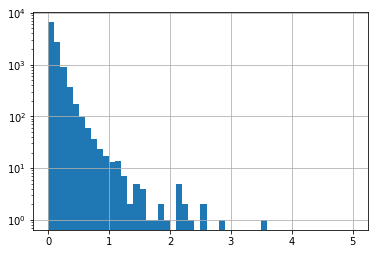

In [49]:
val_y["label_high_20"].hist(bins=50,range=(0,5),log=True)

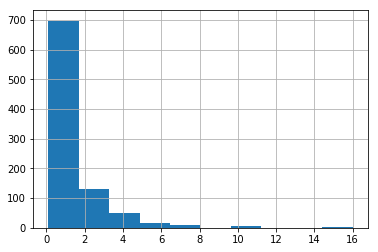

In [43]:
train_X["label_high_20"][train_y["label_high_20"]>0.5]["EndOfDayQuote CumulativeAdjustmentFactor"].hist()

In [45]:
train_X["label_high_20"][train_y["label_high_20"]>0.7]["EndOfDayQuote CumulativeAdjustmentFactor"].describe()

count    447.000000
mean       1.612304
std        1.728605
min        0.100000
25%        1.000000
50%        1.000000
75%        2.000000
max       16.000000
Name: EndOfDayQuote CumulativeAdjustmentFactor, dtype: float64

In [63]:
train_X["label_high_20"][train_y["label_high_20"]>0.7]["EndOfDayQuote CumulativeAdjustmentFactor"].quantile([0, 0.25, 0.5, 0.74,0.9, 0.99,1.0])

0.00     0.100
0.25     1.000
0.50     1.000
0.74     1.012
0.90     4.000
0.99     8.000
1.00    16.000
Name: EndOfDayQuote CumulativeAdjustmentFactor, dtype: float64

In [68]:
train_X["label_high_20"][train_X["label_high_20"]["EndOfDayQuote CumulativeAdjustmentFactor"]!=1]["code"]

2016-02-05    1301
2016-05-09    1301
2016-08-05    1301
2016-04-27    1352
2017-01-31    1352
2016-05-13    1352
2017-05-15    1352
2016-07-28    1352
2017-07-31    1352
2016-10-31    1352
2016-01-12    1401
2017-01-10    1401
2016-07-08    1401
2016-07-11    1401
2017-01-06    1401
2016-01-14    1407
2017-01-13    1407
2018-01-12    1407
2016-04-14    1407
2017-04-14    1407
2018-04-13    1407
2016-07-14    1407
2017-07-14    1407
2018-07-13    1407
2016-10-14    1407
2017-10-13    1407
2018-10-12    1407
2016-02-10    1414
2017-02-10    1414
2018-02-09    1414
              ... 
2016-04-14    9977
2017-04-14    9977
2018-04-13    9977
2016-07-05    9977
2017-10-04    9977
2018-07-05    9977
2016-10-04    9977
2017-10-05    9977
2016-03-31    9982
2017-04-17    9982
2016-09-20    9982
2016-11-21    9982
2016-12-26    9982
2016-04-21    9984
2017-02-08    9984
2018-02-07    9984
2016-05-10    9984
2017-05-10    9984
2018-05-09    9984
2016-07-28    9984
2017-08-07    9984
2018-08-06  

In [69]:
train_X["label_high_20"][train_X["label_high_20"]["code"]==9984]["EndOfDayQuote CumulativeAdjustmentFactor"]

2016-04-21    2.0
2017-02-08    2.0
2018-02-07    2.0
2016-05-10    2.0
2017-05-10    2.0
2018-05-09    2.0
2016-07-28    2.0
2017-08-07    2.0
2018-08-06    2.0
2016-11-07    2.0
2017-11-06    2.0
2018-11-05    2.0
Name: EndOfDayQuote CumulativeAdjustmentFactor, dtype: float64

In [8]:
dfs["stock_labels"]

,base_date,Local Code,label_date_5,label_high_5,label_low_5,label_date_10,label_high_10,label_low_10,label_date_20,label_high_20,label_low_20
datetime,,,,,,,,,,,
2016-01-04,2016-01-04,1301,2016-01-12,0.01091,-0.04000,2016-01-19,0.01091,-0.05455,2016-02-02,0.01091,-0.08727
2016-01-05,2016-01-05,1301,2016-01-13,0.00362,-0.04348,2016-01-20,0.00362,-0.07609,2016-02-03,0.00362,-0.09058
2016-01-06,2016-01-06,1301,2016-01-14,0.00000,-0.05072,2016-01-21,0.00000,-0.08696,2016-02-04,0.00362,-0.09058
2016-01-07,2016-01-07,1301,2016-01-15,0.01107,-0.03321,2016-01-22,0.01107,-0.07380,2016-02-05,0.02214,-0.07380
2016-01-08,2016-01-08,1301,2016-01-18,0.01111,-0.03333,2016-01-25,0.01111,-0.07037,2016-02-08,0.02593,-0.07037
2016-01-12,2016-01-12,1301,2016-01-19,0.02652,-0.01515,2016-01-26,0.02652,-0.04924,2016-02-09,0.04924,-0.04924
2016-01-13,2016-01-13,1301,2016-01-20,-0.01115,-0.05204,2016-01-27,-0.01115,-0.06691,2016-02-10,0.02974,-0.06691
2016-01-14,2016-01-14,1301,2016-01-21,0.01141,-0.04183,2016-01-28,0.01521,-0.04563,2016-02-12,0.05323,-0.04943
2016-01-15,2016-01-15,1301,2016-01-22,-0.00377,-0.05283,2016-01-29,0.03019,-0.05283,2016-02-15,0.04528,-0.05660
